## View Sets in DRF

Django Rest framework allows you to combine the logic for a set of related views in a single class, called a viewset.
There are two main advantages of using a viewset over a view class.
- Repeated logic can be combined into a single class.
- By using Routers, we no longer need to deal with wiring up the URL conf ourselves.

View set class is simply a class based view that provides the method handlers for get() and post() etc.
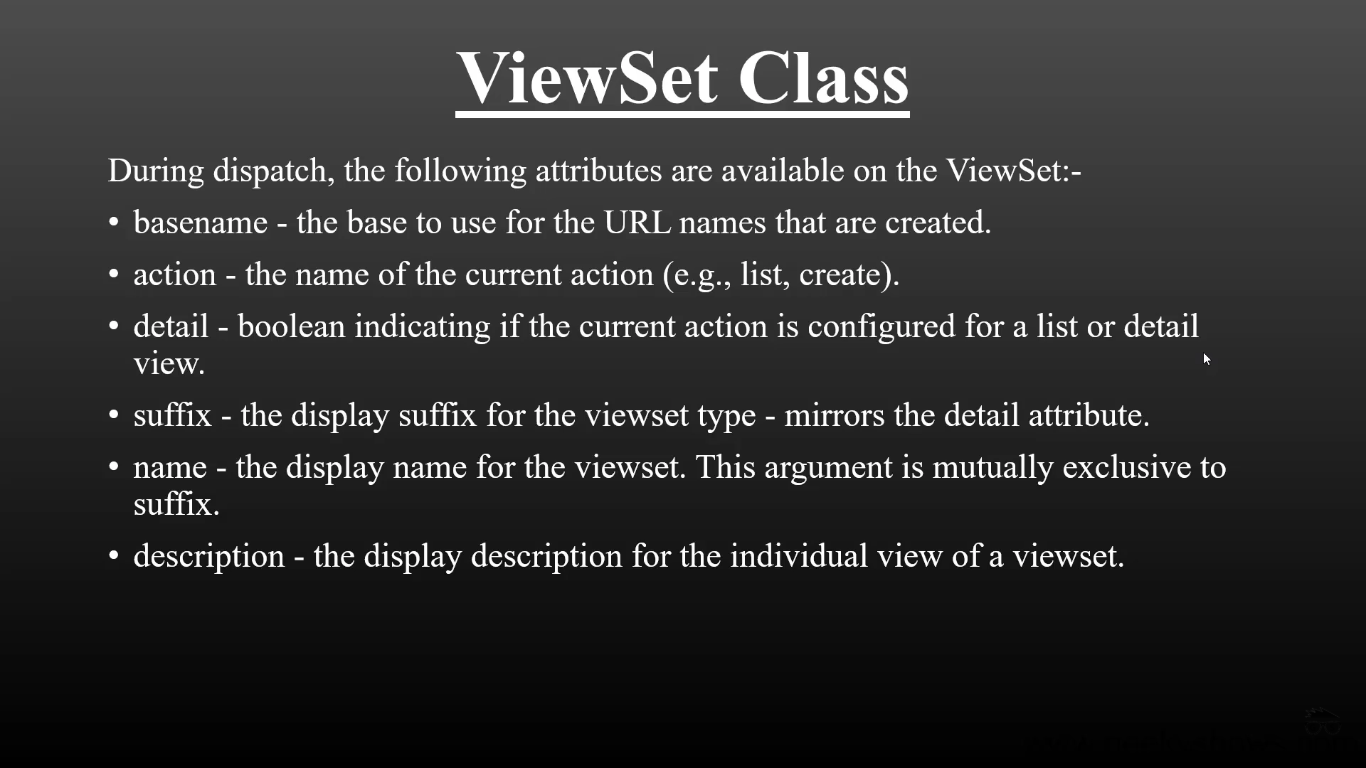

We can use the above provided views to check which action is being performed and is helpful while browsing the API in the web browser.

We also need to set URLs in `urls.py` file using the following method:
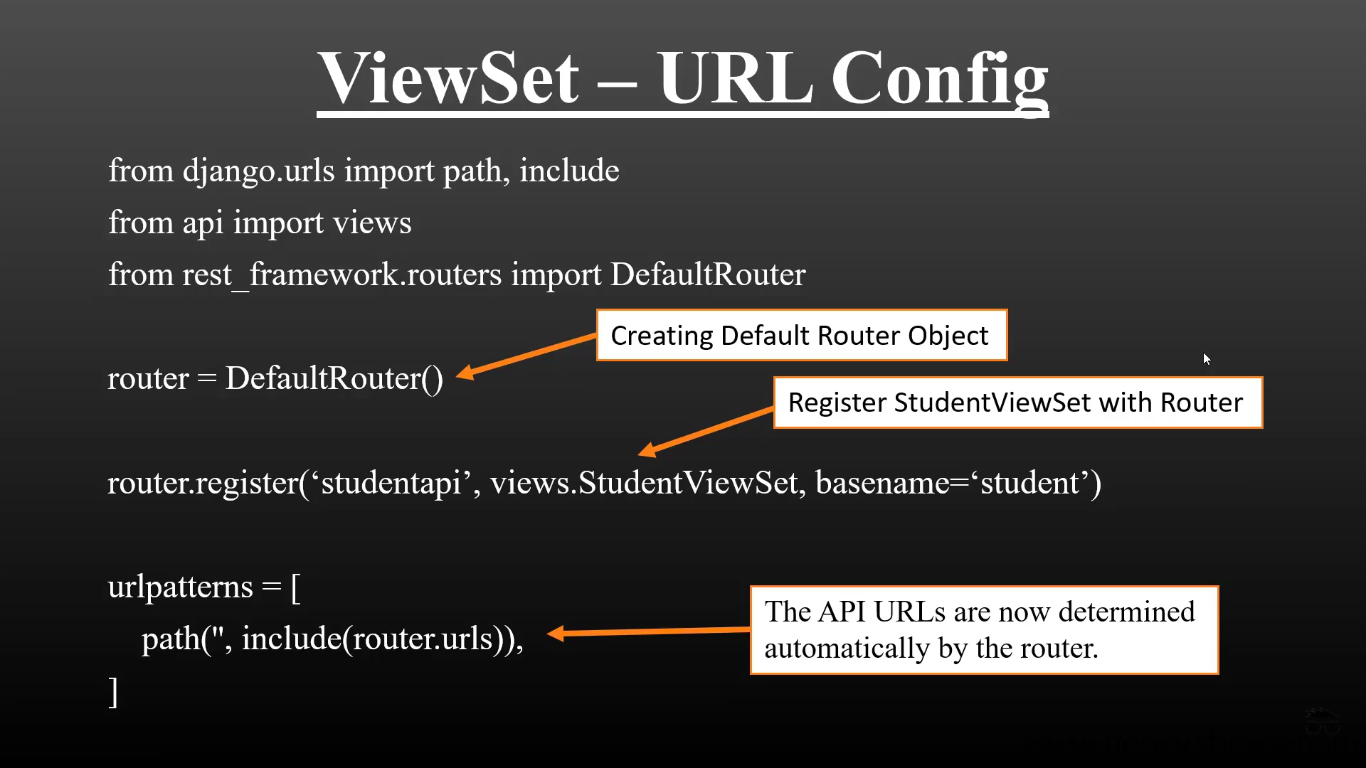

We need to register the the viewset created in `views.py` into the `urls.py` using the `DefaultRouter` module provided by `rest_framework`
<br> **Note:** The urls are handled automatically by `router.urls` file. It has pre-defined url patterns. 

To create a `ViewSet` in `views.py` we can use the code:
```
from django.shortcuts import render
from rest_framework.response import Response
from .models import Student
from .serializers import StudentSerializer
from rest_framework import status
from rest_framework import viewsets

class StudentViewSet(viewsets.ViewSet):
    
    def list(self, request):
        stu = Student.objects.all()
        serializer = StudentSerializer(stu, many=True)
        return Response(serializer.data)

    def retrieve(self, request, pk):
        id = pk
        if id is not None:
            stu = Student.objects.get(id=id)
            serializer = StudentSerializer(stu)
            return Response(serializer.data)

    def create(self, request):
        serializer = StudentSerializer(data=request.data)
        if serilizer.is_valid():
            serializer.save()
            return Response({'msg':'Data Created'}, status=status.HTTP_201_CREATED)
        return Response(serializer.errors, status=status.HTTP_400_BAD_REQUEST)

    def update(self, request, pk):
        id = pk
        stu = Student.objects.get(pk=id)
        serialzier = StudentSerialzier(stu, request.data)
        if serializer.is_valid():
            serializer.save()
            return Response({'msg':'Complete Data Updated'}, status=status.HTTP_201_CREATED)
        return Response(serializer.errors, status=status.HTTP_400_BAD_REQUEST)

    def partial_update(self, request, pk):
        id = pk
        stu = Student.objects.get(pk=id)
        serialzier = StudentSerialzier(stu, request.data, partial=True)
        if serializer.is_valid():
            serializer.save()
            return Response({'msg':'Partial Data Updated'}, status=status.HTTP_201_CREATED)
        return Response(serializer.errors, status=status.HTTP_400_BAD_REQUEST)

    def destroy(self, request, pk):
        id = pk
        stu = Student.objects.get(pk=id)
        stu.delete()
        return Response({'msg':'Data Deleted Success!'})
```

Now In `urls.py` we have to include the router so django would know where are the urls placed.
<br>
we can use the following code:
```
from django.contrib import admin
from django.urls import path, include
from api import views
from rest_framework.routers import DefaultRouter

# creating router
router = DefaultRouter

# register viewset with router
router.register('studentapi', views.StudentViewSet, basename='student')

# Urls
urlpatterns = [
    path('admin/', admin.site.urls),
    path('', include(router.urls)),
]
```

### Model View Set
It inherits the GenericAPIView and includes implementations for various actions, by mixing the behaviours of different mixin classes.
<br>Provides few line code and handle all the API logic
```
from .models import Student
from .serializers import StudentSerializer
from rest_framework import viewsets

class StudentModelViewSet(viewsets.ModelViewSet):
    queryset = Student.objects.all()
    serializer_class = StudentSerializer
```

### Read-Only ModelViewSet
It does not provide the update, delete and post implemenetation too the end user
```
from .models import Student
from .serializers import StudentSerializer
from rest_framework import viewsets

class StudentReadOnlyModelViewSet(viewsets.ReadOnlyModelViewSet):
    queryset = Student.objects.all()
    serializer_class = StudentSerializer

```

### Authentication and Permissions
Right now Our APIs don't have any mechanism to authenticate the users and let them perform specified tasks only.
Authentication is done at very start of view before checking `permissions` and `throttling`.
<br> Drf Provides different types of Authentication mechanisms including:
- Basic Authentication
- Session Authentication
- Token Authentication
- Remote User Authentication
- Custom Authentication

### Basic Authentication
- It uses HTTP Basic Authentication, signed against a user's username and password.
- It is good for testing purpose only. Not recommended for `Production` environment.
- If successfully authenticated, BasicAuthentication provides the following credentials.
- `request.user` will be a Django user instance.
- `request.auth` will be None.

**Note:** If you use BasicAuthentication in production you must `ensure that your API is available over https`

**Note:** You should also ensure that your API clients will always request the username and password at login, and will never store those details to persistent storage.

### Permission
Permission are used to grant or deny access for different classes of users to different parts of the API. It uses the information in `request.user` and `request.auth` properties to determine if the incoming request should be permitted.

### Permission classes in DRF
- ***AllowAny***: Default and will allow both Authenticated and Un-Authenticated users
- ***IsAuthenticated***: Allow only Authenticated users
- ***IsAdminUser***: Deny every other user except with `is_staff = True`
- IsAuthenticatedOrReadOnly
- DjangoModelPermissions
- DjangoModelPermissionsOrAnonReadOnly
- DjangoObjectPermissions
- CustomPermissions

### How to implement BasicAuthentication?
In `views.py` let's say we have implemented `ModelViewSet`, we can use BasicAuthentication as follows:
```
from .models import Student
from .serializers import StudentSerializer
from rest_framework import viewsets
from rest_framework.authentication import BasicAuthentication
from rest_framework.permsissions import IsAuthenticated

class StudentModelViewSet(viewsets.ModelViewSet):
    queryset = Student.objects.all()
    serializer_class = StudentSerializer
    authentication_classes = [BasicAuthentication]
    permission_classes = [IsAuthenticated]
```

### How to define Authentication Globally?
Global Authentication is useful when we want a threshold to be followed by all views inside `views.py`. This way we have a standardized authentication throughtout the users. However, if we want to change the permissions for one user or a view class separately then it can be done as given above inside the class. THis will overwrite the global implementation for that class specifically.
<br> To implement we can follow the code below:
In `settings.py`, we have to include this code at the end: <br>
```
REST_FRAMEWORK = {
    'DEFAULT_AUTHENTICATION_CLASSES' : ['rest_framework.authentication.BasicAuthentication'],
    'DEFAULT_PERMISSION_CLASSES' : ['rest_framework.permissions.IsAuthenticated']
}
```

***Note:*** We can apply other permission classes as well the same way we did above.
<br>***Note2:*** We commonly have 3 types of users in django:
- `SuperUser`: the root user with all the permissions
- `AdminUser`: these users have `is_staff` set as true but they don't have some root permissions
- `NormalUser`: these users have `is_staff` false and have least priviledge normally

### Session Authentication
This authentication scheme Django's default session backend for authentication. Session Authentication is appropriate for AJAX client that are running in the same session context as your website. On successful authentication, it provides the following credentials:
- `request.user` will be a Django user instance.
- `request.auth` will be None.
---
### What is AJAX and how they differ from Java servlets?
AJAX (Asynchronous JavaScript and XML) and Java Servlets are related but distinct technologies in web development. They are not "like" each other in the sense of being interchangeable or serving the same primary purpose. Instead, they often work together to achieve dynamic web applications.
- ***AJAX***:
- Client-side technique:
AJAX is a set of web development techniques used on the client-side (in the browser) to create asynchronous HTTP requests.
- Purpose:
It allows web pages to update parts of their content without requiring a full page reload, leading to more responsive and interactive user experiences.
- Mechanism:
It uses JavaScript's XMLHttpRequest object (or newer alternatives like fetch API) to send and receive data from the server in the background.
-  ***Java Servlets*** :
- Server-side technology: Servlets are Java classes that extend the capabilities of web servers.
- Purpose: They handle requests from clients (like web browsers) and generate dynamic responses, often involving server-side logic, database interactions, and data processing.
- Mechanism: Servlets run on a web server (e.g., Apache Tomcat) and process incoming HTTP requests, then send back responses, which can be HTML, XML, JSON, or other data formats.
<br>***How they work together***:
AJAX requests are often sent to a Java Servlet on the server. The Servlet processes the request, performs necessary operations (e.g., retrieving data from a database), and then sends back a response (often in JSON or XML format). The AJAX client-side code then receives this response and uses JavaScript to dynamically update the relevant parts of the web page without a full refresh.
<br>***In summary***:
- AJAX is a client-side technique: for asynchronous communication.
- Servlets are server-side components: for handling requests and generating responses.
They are complementary technologies that can be combined to build dynamic and responsive web applications in Java. (source:google)

---
### Safe HTTP methods:
- GET, HEAD, OPTIONS
### Unsafe HTTP methods:
- PUT, PATCH, POST or DELETE

### Session Authentication
If you're using AJAX style API with SessionAuthentication, you'll need to make sure you include a valid CSRF token for any unsafe HTTP methods.

### How to implement?
Change the BasicAuthentication code given above.
```
from .models import Student
from .serializers import StudentSerializer
from rest_framework import viewsets
from rest_framework.authentication import SessionAuthentication
from rest_framework.permsissions import IsAuthenticated

class StudentModelViewSet(viewsets.ModelViewSet):
    queryset = Student.objects.all()
    serializer_class = StudentSerializer
    authentication_classes = [SessionAuthentication]
    permission_classes = [IsAuthenticated]

```

***Note***: when we implemented the code of `BasicAuthentication` with `IsAuthenticated` as permission then whenever we hit the url, the user had to enter username and passowrd in a prompt to proceed further. But in `SessionAuthentication` this doesn't happen and the user get an error. We need to enable a login page for this purpose. To do this we can add the code to the `urls.py` file as below:  
```
# import path and include here
from api import views
from rest_framework.routers import DefaultRouter

# creating router project
router = DefaultRouter()

# Register StudentViewSet with Router
router.register('studentapi', views.StudentModelViewSet, basename='student')

urlpatterns = [
    path('admin/', admin.site.urls),
    path('', include(router.urls)),
    path('auth/', include('rest_framework.urls', namespace='rest_framework'))
]
```